In [1]:
import numpy as np
import scipy
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from utils_extended import *
import gpboost as gpb
from pdpbox import pdp
import pystan 
import arviz as az

In [2]:
run_number = 1

## Data pre-processing

In [3]:
data_train_full_raw = pd.read_csv(f'Sheffield/train_test_sets/data_train_full_sheffield_{run_number}.csv').drop(columns=['site'])
test_extrapolation_raw = pd.read_csv(f'Sheffield/train_test_sets/test_extrapolation_sheffield_{run_number}.csv').drop(columns=['site'])
test_interpolation_raw = pd.read_csv(f'Sheffield/train_test_sets/test_interpolation_sheffield_{run_number}.csv').drop(columns=['site'])

# One-hot encode categorical features
data_train_full_raw2 = encode(data_train_full_raw)
test_extrapolation = encode(test_extrapolation_raw)
test_interpolation_raw2 = encode(test_interpolation_raw)

# Dummy encode categorical features for linear model
data_train_full2_raw2 = encode(data_train_full_raw, linear=True)
test_extrapolation2 = encode(test_extrapolation_raw, linear=True)
test_interpolation2_raw2 = encode(test_interpolation_raw, linear=True)

# Fix missing columns
test_extrapolation['disease_Obstructive'] = 0
data_train_full_raw2['gender_Unknown'] = 0
data_train_full_raw2['ethnicity_Asian'] = 0
data_train_full_raw2['disease_Vascular'] = 0
data_train_full = data_train_full_raw2[list(test_extrapolation.columns.values)]

test_interpolation_raw2['gender_Unknown'] = 0
test_interpolation_raw2['ethnicity_Asian'] = 0
test_interpolation_raw2['disease_Vascular'] = 0
test_interpolation = test_interpolation_raw2[list(test_extrapolation.columns.values)]

test_extrapolation2['disease_Obstructive'] = 0
data_train_full2_raw2['gender_Unknown'] = 0
data_train_full2_raw2['ethnicity_Caucasian'] = 0
data_train_full2_raw2['disease_Vascular'] = 0
data_train_full2 = data_train_full2_raw2[list(test_extrapolation2.columns.values)]

test_interpolation2_raw2['gender_Unknown'] = 0
test_interpolation2_raw2['ethnicity_Caucasian'] = 0
test_interpolation2_raw2['disease_Vascular'] = 0
test_interpolation2 = test_interpolation2_raw2[list(test_extrapolation2.columns.values)]

data_train_list, data_val_list = [], []

for i in range(5):
    train_raw = pd.read_csv('Sheffield/tuning_data/data_cv_train_sheffield_' + str(i+1) + '.csv').drop(columns=['site'])
    train = encode(train_raw)
    val_raw = pd.read_csv('Sheffield/tuning_data/data_cv_val_sheffield_' + str(i+1) + '.csv').drop(columns=['site'])
    val = encode(val_raw)
    data_train_list.append(train)
    data_val_list.append(val)

data_cv_list = [pd.concat([data_train_list[i], data_val_list[i]], ignore_index=True).reset_index(drop=True).fillna(0) for i in range(5)]

# Get indices of training and validation sets for cross-validation
data_cv_indices_list = []
for i in range(5):
    data_cv_indices_list.append((np.arange(len(data_train_list[i])), np.arange(len(data_train_list[i]), len(data_train_list[i])+len(data_val_list[i]))))

# Train/test split
train_X, train_y = data_train_full.drop(columns=['egfr']), data_train_full['egfr'].to_numpy(dtype=np.float64)
test_extrapolation_X, test_extrapolation_y = test_extrapolation.drop(columns=['egfr']), test_extrapolation['egfr'].to_numpy(dtype=np.float64)
test_interpolation_X, test_interpolation_y = test_interpolation.drop(columns=['egfr']), test_interpolation['egfr'].to_numpy(dtype=np.float64)
data_train_full_gpb = gpb.Dataset(data=train_X.drop(columns=['ID', 'times']), label=train_y)
data_train_full_gpb_cat = gpb.Dataset(data=train_X, label=train_y, categorical_feature=['ID'])


# For linear
train_X2 = data_train_full2.drop(columns=['egfr'])
test_extrapolation_X2 = test_extrapolation2.drop(columns=['egfr'])
test_interpolation_X2 = test_interpolation2.drop(columns=['egfr'])
data_train_full2_gpb = gpb.Dataset(data=train_X2.drop(columns=['ID', 'times']), label=train_y)


# CV sets
dataset_list , dataset_list_cat = [] , []
for i in range(5):
    cv_train_X, cv_train_y = data_cv_list[i].drop(columns=['egfr']), data_cv_list[i]['egfr'].to_numpy()
    dataset_list.append(gpb.Dataset(data=cv_train_X.drop(columns=['ID', 'times']), label=cv_train_y))
    dataset_list_cat.append(gpb.Dataset(data=cv_train_X, label=cv_train_y, categorical_feature=['ID']))

## Tuning the Gradient Boosted tree with group as categorical variable

In [3]:
# Candidate parameter grid
param_grid = {'num_leaves': [10, 50, 200, 500, 1000, 5000], 
              'max_depth': [1, 3, 5, 10, 50],
              'min_data_in_leaf': [5, 20, 50, 100, 150], 
               'learning_rate' : [0.01, 0.1, 0.3, 0.5, 0.8, 1, 1.2, 1.5, 2]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0}
          #'learning_rate' : 1.5}
          #'device_type' : 'gpu'}

opt_params = grid_search_tune_parameters_multiple(data_cv_list, dataset_list_cat, param_grid, params=params, num_try_random=None,
                                         num_boost_round=10_000,
                                         use_gp_model_for_validation=False, train_gp_model_cov_pars=False, folds_list=data_cv_indices_list, nfold=5, stratified=False, shuffle=False,
                                         metrics='rmse', fobj=None, feval=None, init_model=None,
                                         feature_name='auto', categorical_feature=['ID'],
                                         early_stopping_rounds=10, fpreproc=None,
                                         verbose_eval=1, seed=0, callbacks=None,
                                         gp_model_type=None)
                                                  
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 1350 parameter combinations...
Trying parameter combination 1 of 1350: {'num_leaves': 10, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01} ...
***** New best score (16.686804287269936) found for the following parameter combination:
{'num_leaves': 10, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01, 'num_boost_round': 800.0}
Trying parameter combination 2 of 1350: {'num_leaves': 50, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01} ...
Trying parameter combination 3 of 1350: {'num_leaves': 200, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01} ...
Trying parameter combination 4 of 1350: {'num_leaves': 500, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01} ...
Trying parameter combination 5 of 1350: {'num_leaves': 1000, 'max_depth': 1, 'min_data_in_leaf': 5, 'learning_rate': 0.01} ...
***** New best score (16.686804287269933) found for the following parameter combination:
{'num_leaves': 

In [4]:
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Best number of iterations:  9.8
Best score:  16.206205233938114
Best parameters:  {'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 50, 'learning_rate': 0.5}


## NOTE: Vecchia approximation can't be used with grouped random effects (ie. can't have a random intercept in the random effects model)

## Tuning the GPBoost model with a shared GP using the Vecchia approximation

In [5]:
# Candidate parameter grid
param_grid = {'num_leaves': [50, 1000, 5000], 
              'max_depth': [3, 10, 50, 100],
              'min_data_in_leaf': [5, 10, 50, 100], 
               'learning_rate' : [1.5, 2]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0}
          #'learning_rate' : 1.5}
          #'device_type' : 'gpu'}

n_neighbors = 30
ordering = 'random'
pred_type = 'order_pred_first'
n_neighbors_pred = 30

opt_params = grid_search_tune_parameters_multiple(data_cv_list, dataset_list, param_grid, params=params, num_try_random=None,
                                         num_boost_round=5000,
                                         use_gp_model_for_validation=True, train_gp_model_cov_pars=False, folds_list=data_cv_indices_list, nfold=5, stratified=False, shuffle=False,
                                         metrics='rmse', fobj=None, feval=None, init_model=None,
                                         feature_name='auto',
                                         early_stopping_rounds=10, fpreproc=None,
                                         verbose_eval=1, seed=0, callbacks=None,
                                         gp_model_type='Shared GP', 
                                         num_neighbors=n_neighbors, 
                                         vecchia_ordering=ordering, 
                                         vecchia_pred_type=pred_type, 
                                         num_neighbors_pred=n_neighbors_pred)
                                                  

print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 96 parameter combinations...
Trying parameter combination 1 of 96: {'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 5, 'learning_rate': 1.5} ...
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found
[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] N

In [6]:
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Best number of iterations:  816.0
Best score:  16.813756925992298
Best parameters:  {'num_leaves': 50, 'max_depth': 50, 'min_data_in_leaf': 5, 'learning_rate': 1.5}


# Obtaining test set scores for the different models

In [4]:
train_X_features = train_X.drop(columns=['ID', 'times'])
test_extrapolation_X_features = test_extrapolation_X.drop(columns=['ID', 'times'])
test_interpolation_X_features = test_interpolation_X.drop(columns=['ID', 'times'])

train_X2_features = train_X2.drop(columns=['ID', 'times'])
test_extrapolation_X2_features = test_extrapolation_X2.drop(columns=['ID', 'times'])
test_interpolation_X2_features = test_interpolation_X2.drop(columns=['ID', 'times'])
train_X2_linear = np.column_stack((np.ones(len(train_X2_features)), train_X2_features))
test_extrapolation_X2_linear = np.column_stack((np.ones(len(test_extrapolation_X2_features)), test_extrapolation_X2_features))
test_interpolation_X2_linear = np.column_stack((np.ones(len(test_interpolation_X2_features)), test_interpolation_X2_features))

In [5]:
# Create results dataframe
results = pd.DataFrame(columns=['RMSE_interpolation', 'RMSE_extrapolation', 'Time'],
                       index=['Linear Mixed Effects Model with no fixed features (random intercept)',
                              'Linear Mixed Effects Model with Random Intercept',
                              'Linear Mixed Effects Model with Shared Gaussian Process',
                              'Linear Mixed Effects Model with Independent Gaussian Process',
                              'Gradient-boosted tree with group as categorical variable (no random effects)',
                              'GPBoost with Random Intercept',
                              'GPBoost with Shared Gaussian Process using Vecchia',
                              'GPBoost with Independent Gaussian Process'])

In [6]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
np.random.seed(1)
model = gpb.GPModel(group_data=np.column_stack((train_X2['ID'], train_X2['times'])))
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'lr_cov': 0.01, 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=np.ones(len(train_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'Time'] = time.time() - start_time

y_pred_extrapolation = model.predict(group_data_pred=np.column_stack((test_extrapolation_X2['ID'], test_extrapolation_X2['times'])),
                                     X_pred=np.ones(len(test_extrapolation_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))

y_pred_interpolation = model.predict(group_data_pred=np.column_stack((test_interpolation_X2['ID'], test_interpolation_X2['times'])),
                                     X_pred=np.ones(len(test_interpolation_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [7]:
# 2. Linear Mixed Effects Model with Random Intercept
np.random.seed(1)
model = gpb.GPModel(group_data=np.column_stack((train_X2['ID'], train_X2['times'])))
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'lr_cov': 0.01, 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'Time'] = time.time() - start_time

y_pred_extrapolation = model.predict(group_data_pred=np.column_stack((test_extrapolation_X2['ID'], test_extrapolation_X2['times'])),
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))

y_pred_interpolation = model.predict(group_data_pred=np.column_stack((test_interpolation_X2['ID'], test_interpolation_X2['times'])),
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [8]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
np.random.seed(1)
model = gpb.GPModel(group_data=train_X2['ID'], gp_coords=train_X2['times'], cov_function='exponential')
model.set_optim_params(params={'optimizer_cov': 'fisher_scoring'})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'Time'] = time.time() - start_time

y_pred_extrapolation = model.predict(group_data_pred=test_extrapolation_X2['ID'],
                                     gp_coords_pred=test_extrapolation_X2['times'],
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))

y_pred_interpolation = model.predict(group_data_pred=test_interpolation_X2['ID'],
                                     gp_coords_pred=test_interpolation_X2['times'],
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [9]:
# 4. Linear Mixed Effects Model with Independent Gaussian Process
np.random.seed(1)
model = gpb.GPModel(group_data=train_X2['ID'], gp_coords=train_X2['times'], cluster_ids=train_X2['ID'].values.astype(int), cov_function='exponential')
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'lr_cov': 0.01, 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Independent Gaussian Process', 'Time'] = time.time() - start_time

y_pred_extrapolation = model.predict(group_data_pred=test_extrapolation_X2['ID'],
                                     gp_coords_pred=test_extrapolation_X2['times'],
                                     cluster_ids_pred=test_extrapolation_X2['ID'].values.astype(int),
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Independent Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))

y_pred_interpolation = model.predict(group_data_pred=test_interpolation_X2['ID'],
                                     gp_coords_pred=test_interpolation_X2['times'],
                                     cluster_ids_pred=test_interpolation_X2['ID'].values.astype(int),
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Independent Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2)) 

In [10]:
# 5. CatBoost
np.random.seed(1)
params = {'objective': 'regression_l2',
          'learning_rate': 0.5,
          'max_depth': 5,
          'min_data_in_leaf': 50,
          'num_leaves': 10,
          'verbose': 0}


start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb_cat,
                gp_model=None,
                num_boost_round=10, 
                categorical_feature=['ID'])

results.loc['Gradient-boosted tree with group as categorical variable (no random effects)', 'Time'] = time.time() - start_time
y_pred_extrapolation = bst.predict(data=test_extrapolation_X)
results.loc['Gradient-boosted tree with group as categorical variable (no random effects)', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))


y_pred_interpolation = bst.predict(data=test_interpolation_X)
results.loc['Gradient-boosted tree with group as categorical variable (no random effects)', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [11]:
# 6. GPBoost with Random Intercept
np.random.seed(1)
gp_model = gpb.GPModel(group_data=np.column_stack((train_X['ID'], train_X['times'])))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

params = {'objective': 'regression_l2',
          'learning_rate': 0.8,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1988)
                
results.loc['GPBoost with Random Intercept', 'Time'] = time.time() - start_time

pred_extrapolation = bst.predict(data=test_extrapolation_X_features, group_data_pred=np.column_stack((test_extrapolation_X['ID'], test_extrapolation_X['times'])), pred_latent=True)
y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Random Intercept', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))

pred_interpolation = bst.predict(data=test_interpolation_X_features, group_data_pred=np.column_stack((test_interpolation_X['ID'], test_interpolation_X['times'])), pred_latent=True)
y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Random Intercept', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [12]:
# 7. GPBoost with Shared Gaussian Process using Vecchia approximation
np.random.seed(1)

n_neighbors = 30
num_bst_round = 816
params = {'objective': 'regression_l2',
          'num_leaves': 50,
          'learning_rate': 1.5,
          'max_depth': 50,
          'min_data_in_leaf': 5,
          'verbose': 0}

gp_model = gpb.GPModel(gp_coords=train_X['times'], vecchia_approx=True, num_neighbors=n_neighbors, vecchia_ordering='random', 
                                                                    vecchia_pred_type='order_pred_first', num_neighbors_pred=n_neighbors)
                                                                    
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})


start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=num_bst_round)

results.loc['GPBoost with Shared Gaussian Process using Vecchia', 'Time'] = time.time() - start_time
pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 gp_coords_pred=test_extrapolation_X['times'], pred_latent=True)

y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Shared Gaussian Process using Vecchia', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))

pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 gp_coords_pred=test_interpolation_X['times'], pred_latent=True)

y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Shared Gaussian Process using Vecchia', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found


In [13]:
# 8. GPBoost with Independent Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'].values.astype(int))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1350)
results.loc['GPBoost with Independent Gaussian Process', 'Time'] = time.time() - start_time

pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 group_data_pred=test_extrapolation_X['ID'],
                                 gp_coords_pred=test_extrapolation_X['times'],
                                 cluster_ids_pred=test_extrapolation_X['ID'].values.astype(int), pred_latent=True)
y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Independent Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))

pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 group_data_pred=test_interpolation_X['ID'],
                                 gp_coords_pred=test_interpolation_X['times'],
                                 cluster_ids_pred=test_interpolation_X['ID'].values.astype(int), pred_latent=True)
y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Independent Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [14]:
results.to_csv(f'Sheffield_results/sheffield_results_{run_number}.csv')

In [15]:
# Tuned Vecchia with 30 neighbors
results

,RMSE_interpolation,RMSE_extrapolation,Time
Linear Mixed Effects Model with no fixed features (random intercept),12.710275,21.533285,2.484933
Linear Mixed Effects Model with Random Intercept,12.98405,19.30723,4.502563
Linear Mixed Effects Model with Shared Gaussian Process,12.91585,19.223365,266.397397
Linear Mixed Effects Model with Independent Gaussian Process,12.136107,19.246463,1.143385
Gradient-boosted tree with group as categorical variable (no random effects),14.121841,14.751675,0.045113
GPBoost with Random Intercept,10.447455,15.179911,178.388663
GPBoost with Shared Gaussian Process using Vecchia,13.799893,15.965377,272.785001
GPBoost with Independent Gaussian Process,9.803018,15.200519,51.58689


### Model interpratation  

Let's now delve deeper into interpreting these models and try to understand how they work. In particular, we will focus on the GPBoost model with an independent gaussian process component since the Gradient Boosted tree part of the model offers feature importance functionality.

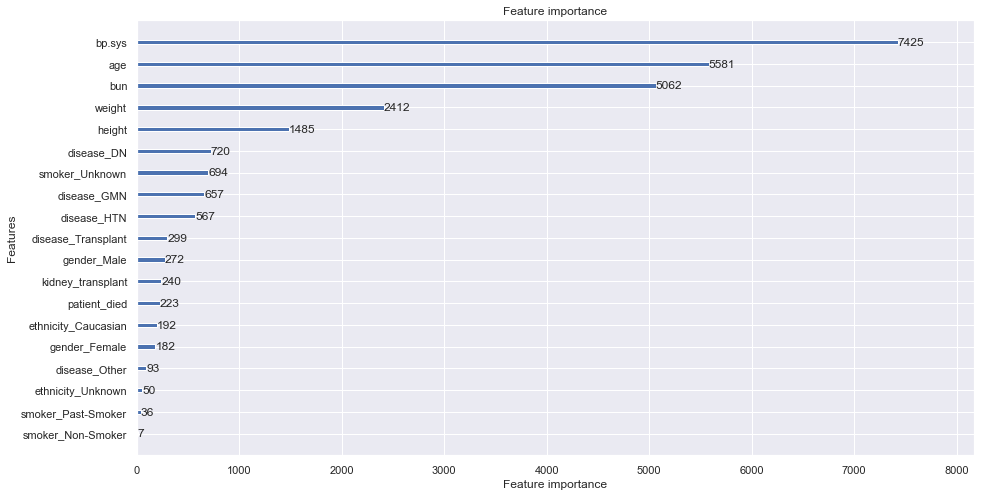

In [8]:
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'].values.astype(int))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 10,
          'min_data_in_leaf': 120,
          'verbose': 0}

bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1238)

# Plotting feature importances
gpb.plot_importance(bst, figsize=(15, 8));

According to the above plot, systolic blood pressure, age and blood urea nitrogen level ('bun') seem to be by far the most important features in predicting eGFR values. Therefore, we will try to get a more intuitive understanding of their relationship using a partial dependence plot. In our case, a partial dependence plot shows the marginal effects of the specific feature on the eGFR values.  

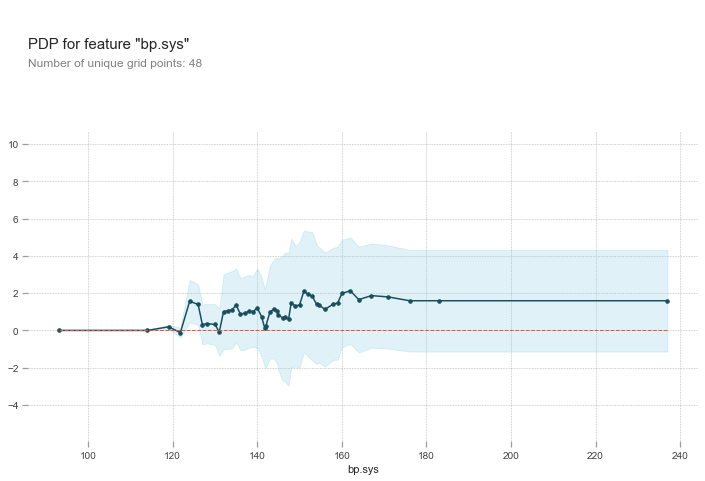

In [21]:
# Single variable plots (takes a few seconds to compute)
pdp_dist = pdp.pdp_isolate(model=bst, dataset=train_X_features,      
                           model_features=train_X_features.columns,
                           feature='bp.sys', 
                           num_grid_points=50,
                           predict_kwds={"ignore_gp_model": True});

pdp.pdp_plot(pdp_dist, 'bp.sys', plot_lines=False, figsize=(12, 8));

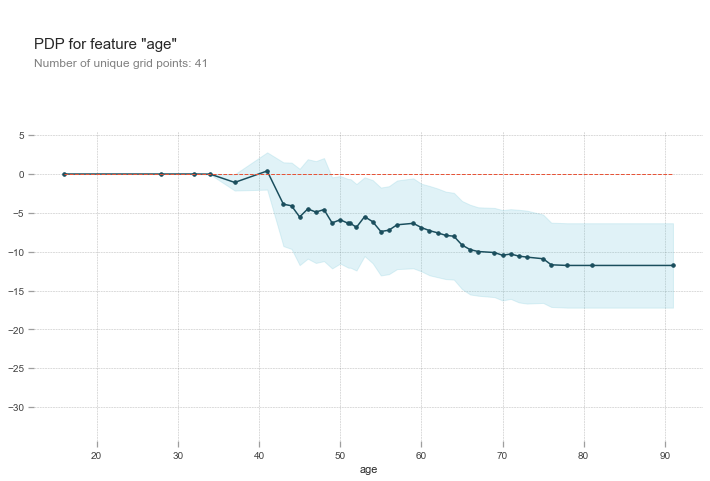

In [22]:
# Single variable plots (takes a few seconds to compute)
pdp_dist = pdp.pdp_isolate(model=bst, dataset=train_X_features,      
                           model_features=train_X_features.columns,
                           feature='age', 
                           num_grid_points=50,
                           predict_kwds={"ignore_gp_model": True});

pdp.pdp_plot(pdp_dist, 'age', plot_lines=False, figsize=(12, 8));

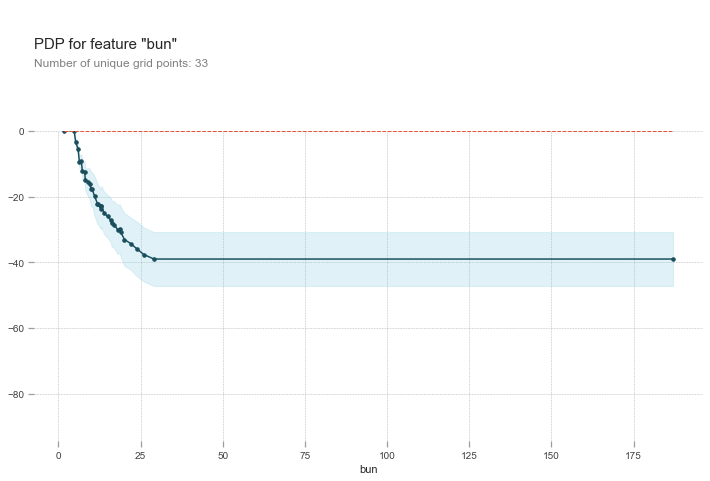

In [23]:
# Single variable plots (takes a few seconds to compute)
pdp_dist = pdp.pdp_isolate(model=bst, dataset=train_X_features,      
                           model_features=train_X_features.columns,
                           feature='bun', 
                           num_grid_points=50,
                           predict_kwds={"ignore_gp_model": True});

pdp.pdp_plot(pdp_dist, 'bun', plot_lines=False, figsize=(12, 8));

## Stan analysis of the kernel hyperparameters

In [7]:
# 8. GPBoost with Independent Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'].values.astype(int))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1350)

pred_training = bst.predict(data=train_X_features,
                                 group_data_pred=train_X['ID'],
                                 gp_coords_pred=train_X['times'],
                                 cluster_ids_pred=train_X['ID'].values.astype(int), pred_latent=True, predict_var=True)

y_pred_training = pred_training['fixed_effect'] + pred_training['random_effect_mean']

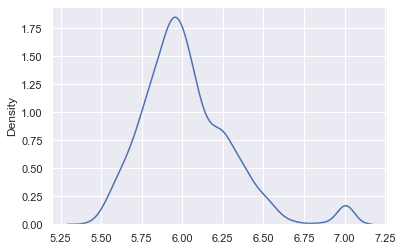

In [20]:
# Let's see the uncertainty in the predicted random effects; most predictions seem to have roughly similar levels of uncertainty 
pred_std = np.sqrt(pred_training['random_effect_cov'])
sns.kdeplot(pred_std);

In [8]:
gp_model.get_cov_pars()

,Error_term,ID,GP_var,GP_range
Param.,26.264221,7.550201,166.184644,4139.88847


In [9]:
gp_code = """
// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;

}
parameters {

  real<lower=3500> rho; // kernel lengthscale
  real<lower=0> sigma_sq; // kernel marginal variance
  
}
model {
  matrix[N, N] L_K;
  matrix[N,N] K;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      K[i,j] <- sigma_sq * exp(- 1/rho * pow(x[i] - x[j],2));
      K[j,i] <- K[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    K[k,k] <- 0.25 + sigma_sq; // assume known error term variance is 0.25 (then K[k, k] = sigma_sq + error term variance)
  
  L_K = cholesky_decompose(K);
  
    // Sigma[k,k] <- eta_sq + sigma_sq; // + jitter


  rho ~ normal(5000, 1000);
  sigma_sq ~ normal(150, 100);

  y ~ multi_normal_cholesky(mu, L_K);
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_87862c32e476793505ad312f6e744d70 NOW.


Inference for Stan model: anon_model_87862c32e476793505ad312f6e744d70.
1 chains, each with iter=1000; warmup=300; thin=1; 
post-warmup draws per chain=700, total post-warmup draws=700.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
rho      3500.2    0.01   0.26 3500.0 3500.9    503    1.0
sigma_sq 3358.0    3.66  75.97 3211.2 3513.8    432    1.0

Samples were drawn using NUTS at Tue Jul  5 16:36:09 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


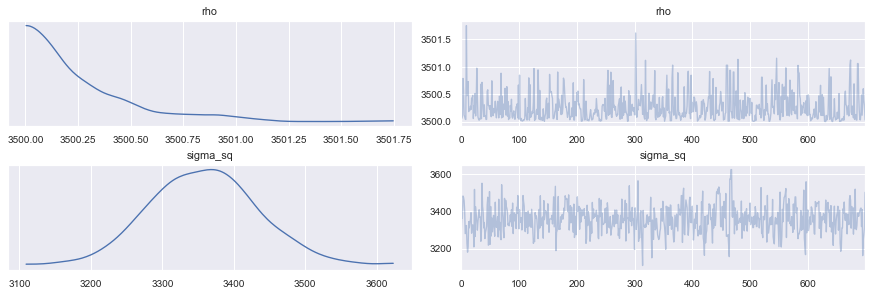

In [10]:
# Obtain the posterior of the kernel hyperparameters using MCMC over a subset of the training data for computational reasons
subset_index = np.random.choice(a=len(train_y), size=1000, replace=False)
y_mcmc = train_y[subset_index] - pred_training['fixed_effect'][subset_index]
x_mcmc = train_X['times'][subset_index].values

gp_data = {'N': len(subset_index), 'y': y_mcmc, 'x': x_mcmc}

gp_fit = pystan.stan(model_code=gp_code, data=gp_data,
                  iter=1000, chains=1, warmup=300, n_jobs=-1, seed=1)

# Print a summary 
print(gp_fit.stansummary(pars=['rho', 'sigma_sq'], probs = (0.025, 0.975)))

# Let's visualize the posteriors
ax = az.plot_trace(gp_fit, var_names = ["rho", "sigma_sq"])

## Investigating if the learned hyperparameter posteriors could improve the learning process in GPBoost

Let's see how test set performance would be if one was to use a point estimate from the posterior instead of the learned parameters in GPBoost with individual GPs

In [5]:
np.random.seed(1)
rho_post_mean = gp_fit.to_dataframe()['rho'].mean()
sigma_sq_post_mean = gp_fit.to_dataframe()['sigma_sq'].mean()

gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'].values.astype(int))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1350,
                train_gp_model_cov_pars=True)

# Use posterior means for rho and sigma_sq during prediction time
gp_params = np.concatenate([gp_model.get_cov_pars().values[0][:2] , np.array([sigma_sq_post_mean, rho_post_mean])])


pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 group_data_pred=test_interpolation_X['ID'],
                                 gp_coords_pred=test_interpolation_X['times'],
                                 cluster_ids_pred=test_interpolation_X['ID'].values.astype(int), pred_latent=True)

y_pred_interpolation = pred_interpolation['fixed_effect'] + gp_model.predict(group_data_pred=test_interpolation_X['ID'], gp_coords_pred=test_interpolation_X['times'], 
                                                                                            predict_var=True, cov_pars=gp_params, cluster_ids_pred=test_interpolation_X['ID'].values.astype(int))['mu']

print(np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2)))

pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 group_data_pred=test_extrapolation_X['ID'],
                                 gp_coords_pred=test_extrapolation_X['times'],
                                 cluster_ids_pred=test_extrapolation_X['ID'].values.astype(int), pred_latent=True)

y_pred_extrapolation = pred_extrapolation['fixed_effect'] + gp_model.predict(group_data_pred=test_extrapolation_X['ID'], gp_coords_pred=test_extrapolation_X['times'], 
                                                                                            predict_var=True, cov_pars=gp_params, cluster_ids_pred=test_extrapolation_X['ID'].values.astype(int))['mu']

print(np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2)))

9.79007728957487
15.196416513864241


We can see that performance is significantly reduced. This could be due to a number of reasons, such as the choice of priors used, the limited number of datapoints used due to computational reasons etc. Another important point to mention is that we don't actually know what the true random effects of the underlying data-generating process are, and so we are hoping that the estimated fixed effects part of the GPBoost model are quite close to the true fixed effects.

Let's also see what would happen if we were to use posterior point estimates as initialisation points in the optimization algorithm

In [6]:
# 8. GPBoost with Independent Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'].values.astype(int))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True, 'init_cov_pars':np.array([1, 1, sigma_sq_post_mean, rho_post_mean])})

params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1350,
                train_gp_model_cov_pars=True)

pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 group_data_pred=test_interpolation_X['ID'],
                                 gp_coords_pred=test_interpolation_X['times'],
                                 cluster_ids_pred=test_interpolation_X['ID'].values.astype(int), pred_latent=True)

y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
print(np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2)))


pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 group_data_pred=test_extrapolation_X['ID'],
                                 gp_coords_pred=test_extrapolation_X['times'],
                                 cluster_ids_pred=test_extrapolation_X['ID'].values.astype(int), pred_latent=True)

y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
print(np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2)))

9.825112665522573
15.211770469653523


In [7]:
gp_model.get_cov_pars()

,Error_term,ID,GP_var,GP_range
Param.,26.270936,7.276618,166.425514,4160.386671


Here, we can observe an improvement over the extrapolation test set score even though performance on the interpolation test set decreases.